# Background


## Camera trap is one of the most used automated tools to monitor animal population dynamics.

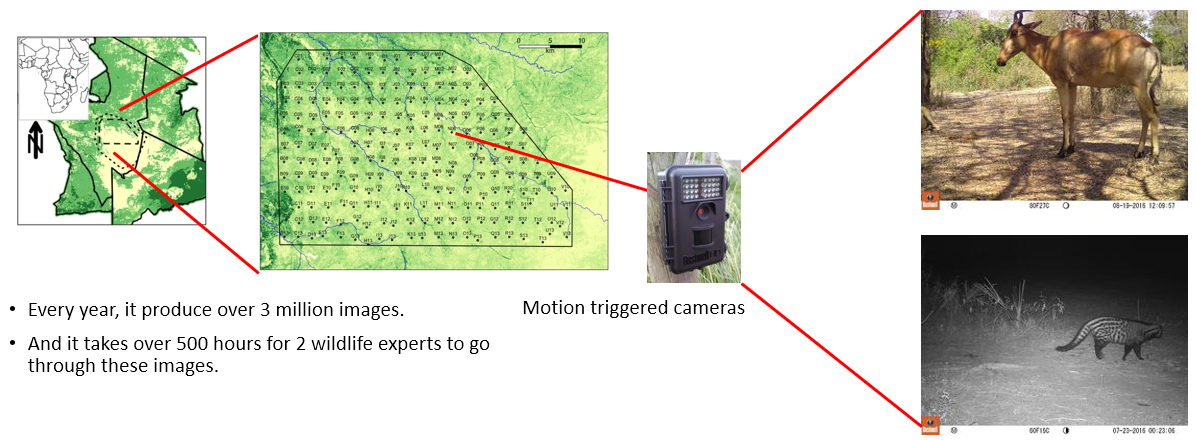

We are currently experiencing rapid, human-driven loss of global biodiversity. To understand the complex patterns, drivers, and consequences of species declines and extinctions, ecologists increasingly employ emerging technology to assist with data collection and processing. Motion-activated remote cameras (henceforth "camera traps") have emerged as a popular non-invasive tool for monitoring terrestrial vertebrate communities. Decreasing cost and increasing reliability have recently led to the application of camera traps for long-term, continuous deployment aiming to monitor entire wildlife communities across multiple seasons and years.

The greatest logistical barrier to long-term monitoring with camera traps is the overwhelming amount of human labor needed to annotate thousands or millions of wildlife images for ecological analysis. This annotation bottleneck creates a considerable mismatch between the pace of data collection and data processing, significantly curtailing the usefulness of camera trap data for on-going conservation and monitoring efforts. For example, a relatively modest camera trap survey (~80 camera traps) captures millions of images a year. We estimate that it would take a single trained expert around 200 full-time working days to annotate one million images. As such, hundreds of human annotators (e.g., experts, trained volunteers, and citizen scientists) are required to keep pace with image accumulation. This need is likely to grow exponentially over the coming decades as more monitoring sites are set up.

## Wildlife recognition with deep learning

The use of deep learning (a subset of AI technology) to automatically identify animals in camera trap images has recently drawn considerable attention from the ecological community. Currently, trained deep learning algorithms can classify a million images in a single day running on a desktop computer, a significant advancement over the months of effort required for human annotators to accomplish the same task

## - In this tutorial:

  1) Pytorch-Lightning as an alternative to vanilla Pytorch for deep learning algorithm development.

  2) Identifying one of the biggest challenges in real-world datasets: extremely imbalanced data distribution (i.e., long-tailed distribution).

  3) Showcasing how simple tweeks of deep learning methods can affect the model performance, and how easy it is to implement different algorithms with Pytorch-Lightning.

  4) Additional discussions on model reliability.

## - Prerequisites:

  1) Basic idea of Python.

  2) Basic idea of deep learning packages like Pytorch.

  3) Basic idea of machine learning.

# Data and packages

## Data background
The data we use for today's tutorial is a part of the [Sanpshot Safari Project](https://www.zooniverse.org/organizations/meredithspalmer/snapshot-safari), collected from Kgalegadi National Park. The full data and the background information can be found on [LILA](https://lila.science/datasets/snapshot-kgalagadi). The portion we use today contains six independent animal species for demonstrative purposes.

## Data download and preparation

- Data and relevant code are shared through this google drive share link: https://drive.google.com/drive/folders/1OCQfnWHI80K8-QOI3lL0ecBCg9-m169c?usp=sharing

- Click on `CCAI_CameraTrap` then select `Organize` and `Add shortcut`. Select `My Drive`.

- Now, you can run the following cells to access the data and additional scripts for this project.

In [ ]:
!gdown https://drive.google.com/uc?id=1XCkKX2e0cg6k2Nn868Obrat6GBXnjFJl

Downloading...
From (original): https://drive.google.com/uc?id=1XCkKX2e0cg6k2Nn868Obrat6GBXnjFJl
From (redirected): https://drive.google.com/uc?id=1XCkKX2e0cg6k2Nn868Obrat6GBXnjFJl&confirm=t&uuid=71f3f851-7b22-4f36-a88c-8be85a08ea83
To: /content/CCAI_CameraTrap.zip
100% 48.1M/48.1M [00:00<00:00, 107MB/s]


In [ ]:
!unzip -oq /content/CCAI_CameraTrap.zip

In [ ]:
# We need three additional package for the this tutorial.
# Pytorch-lightning is an alternative to Pytorch.
# Munch is a packge for easier configuration loading.
! pip install pytorch-lightning munch

## Next, let's take a look at the dataset.

In [ ]:
# Load some dependency packages.
import os
import json
import copy
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from munch import Munch

In [ ]:
# Set up our dataset root directory.
root_dir = '/content/CCAI_CameraTrap/CCAI_Kgalagadi'

# Load the annotation json file of the small dataset.
with open(os.path.join(root_dir, 'ann.json'), 'r') as f:
    ann = json.load(f)

In [ ]:
# The json is loaded as a diction with two keys:
ann.keys()

dict_keys(['categories', 'annotations'])

In [ ]:
# In the category section, we have a label id to category mapping.
ann['categories']

[{'id': '0', 'category': 'gemsbokoryx'},
 {'id': '1', 'category': 'ostrich'},
 {'id': '2', 'category': 'steenbok'},
 {'id': '3', 'category': 'jackalblackbacked'},
 {'id': '4', 'category': 'kudu'},
 {'id': '5', 'category': 'hartebeestred'}]

In [ ]:
# In the annotation section, we have training and validation sets. We don't need test set for this tutorial.
ann['annotations'].keys()

dict_keys(['train', 'val'])

In [ ]:
# Let's see what the annotations look like:
ann['annotations']['train'][:10]

[{'img_id': 'KGA_S1_A01_R1_IMAG0018', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0019', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0020', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0021', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0022', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0023', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0024', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0025', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0026', 'label': '0'},
 {'img_id': 'KGA_S1_A01_R1_IMAG0027', 'label': '0'}]

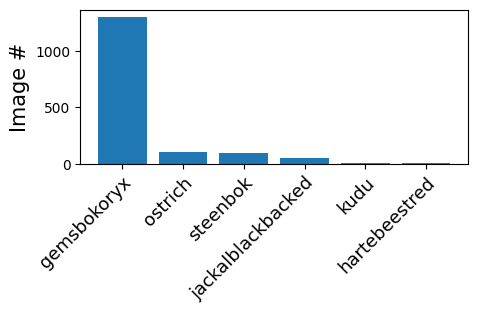

In [ ]:
# Next, let's plot the distribution of this dataset and we can see it is extremely imbalanced.
# We call this long-tailed distribution.
fig = plt.figure(figsize = (5, 2))
plt.bar([i['category'] for i in ann['categories']],
        np.unique([int(i['label']) for i in ann['annotations']['train']], return_counts=True)[1])
plt.ylabel('Image #', size=15)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=13)
plt.show()

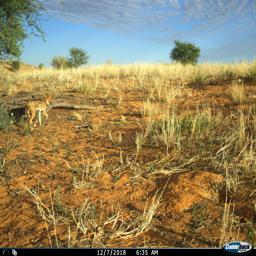

In [ ]:
# Let's print out some example images.
# Please note that the images are all pre resized to 256x256 for the ease of model inputing and demonstration purposes.
i = np.random.randint(0, len(ann['annotations']['train']))
Image.open(os.path.join(root_dir, 'data', ann['annotations']['train'][i]['img_id']+'.JPG'))

- The following code block show how to build a typical Pytorch Dataset class for our dataset

In [ ]:
# Load pytroch dataset relevant dependencies
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# This class is a Pytorch Dataset for our demo dataset.
class Kgalagadi(Dataset):

    # First, we need to set up data augmentations.
    data_transforms = {
        # During training, we need to randomly augment the data with the following augmentation techniques.
        # These are the default procedures used by almost everyone.
        # Ultimately, the data need to be normalized by ImageNet Mean and STD because we will use ImageNet Pretrained model for faster convergence.
        'train': transforms.Compose([
            transforms.RandomResizedCrop((224, 224),
                                         scale=(0.7, 1.0),
                                         ratio=(0.8, 1.2)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2,
                                   contrast=0.2,
                                   saturation=0.2,
                                   hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        # For validation, we don't need random augmentation. Only need to resize the input to be consistent to training data.
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
    }

    def __init__(self, rootdir, dset='train'):
        # Here, we initialize the dataset.
        # Similar to what we did in the previous data sections.
        self.img_root = None
        self.ann_root = None
        self.dset = dset

        # We set up the dataset root.
        self.img_root = os.path.join(rootdir, 'data')

        # We load the annotation json.
        with open(os.path.join(rootdir, 'ann.json'), 'r') as f:
            self.ann = json.load(f)

        # We set up the categorie mapping.
        self.categories = {int(i['id']):i['category']
                           for i in self.ann['categories']}

        # And we load the data.
        self.data = self.ann['annotations'][self.dset]

    def class_counts(self):
        # This function calculates the data number by each class.
        unique_labels, unique_counts = np.unique([int(d['label'])
                                                  for d in self.data],
                                                 return_counts=True)
        return {i[0]:i[1] for i in zip(unique_labels, unique_counts)}

    def __len__(self):
        # Every Pytorch Dataset class needs this function to return the dataset's length.
        return len(self.data)

    def __getitem__(self, index):
        # This is the function determines how the data are actually accessed during training.
        # The index is going to be the index of the dataset.

        # With input index, we can access the actual data we loaded in the initialization.
        file_id = self.data[index]['img_id']
        label = int(self.data[index]['label'])
        file_dir = os.path.join(self.img_root, file_id+'.JPG')

        # Then we use PIL to load the image into memory.
        with open(file_dir, 'rb') as f:
            sample = Image.open(f).convert('RGB')

        # We normalize or augment the data.
        sample = self.data_transforms[self.dset](sample)

        # We return the transformed data, corresponding labels, and actual file pathes for analyze purposes.
        return sample, label, file_dir

In [ ]:
# Once the Dataset class is defined, we can actually load the our Kgalagadi dataset.
# Load training and validation datasets
dset_tr = Kgalagadi('/content/CCAI_CameraTrap/CCAI_Kgalagadi', dset='train')
dset_val = Kgalagadi('/content/CCAI_CameraTrap/CCAI_Kgalagadi', dset='val')

# And datasets need to be loaded with Pytorch DataLoader for batch loading.
# Here we set the batch size to 32.
loader_tr = DataLoader(
            dset_tr, batch_size=32, shuffle=True,
            pin_memory=True, num_workers=2, drop_last=False
        )
loader_val = DataLoader(
             dset_val, batch_size=32, shuffle=False,
             pin_memory=True, num_workers=2, drop_last=False
        )

# Training preparation
- Here, we set up some hyperparameters for our model training.
- And also define an accuracy calculation function to evaluate our model performance.

In [ ]:
# Here we use Munch to set up the configurations.
conf = Munch()
conf.num_epochs = 9 # Number of training epochs.
conf.num_cls = 6 # Number of training classes.
conf.log_interval = 10 # Number of training iterations between each logs.
conf.lr = 0.01 # Learning rate.
conf.step_size = 10 # Learning rate scheduler step size.
conf.gamma = 0.1 # Learning rate decaying rate on each decay step.

In [ ]:
def acc(preds, labels):
    # This function calculates three different accuracies.
    # First we need the confusion matrix of predictions.
    matrix = confusion_matrix(labels, preds)
    # Then we can get the accuracies of each class on the diagnal of the matrix.
    cls_acc = matrix.diagonal() / matrix.sum(axis=1)
    # We calculate the micro accuracy / class average accuracy as the average of the diagnal of confusion matrix.
    mic_acc = matrix.diagonal().sum() / matrix.sum()
    # We also get the typical macro accuracy / dataset average accuracy.
    mac_acc = cls_acc.mean()
    return cls_acc, mac_acc, mic_acc


# Vanilla Pytorch
- In this section, we are going to show how we can build a simple training and validation prodedure with a Convolutional Neural Network Classification (CNN) model for our dataset.
- The model we choose is ResNet-18, which is one of the most widely used CNN model in computer vision applications. It has relatively smaller amount of parameters but can still provide representative classification performance of modern deep learning methods.
- Also to setup the whole training and optimization process, we choose cross-entropy loss and stochastic gradient descent (SGD) optimizers. These two are the most widely applied and default choices in terms of loss functions and model optimizers. People also use Adam optimizer for faster convergences. For our small dataset, there is no differences. However, for larger datasets, sometimes, SGD is a little more stable.  

In [ ]:
# Dependencies of a regular pytorch training procedure.
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.resnet import resnet18 # We use resnet18 as our cnn model.

In [ ]:
# I like to use python classes for such training procedures for cleaner development structure.
# A well built class can also be portable for many kinds of purposes.
class PlainResNet:

    """
    Overall training function.
    """

    name = 'PlainResNet'

    def __init__(self, conf, loaders, weights_path='/content/CCAI_CameraTrap/weights/PlainResNet.ckpt'):

        # First, we need to initialize this training procedure.

        # We need the configurations.
        self.conf = conf
        # We need the weight path whe evaluating the model.
        self.weights_path = weights_path
        # We need to access the dataloaders.
        self.train_loader, self.val_loader = loaders
        # Also need to keep a copy of category mapping here for analyze purposes.
        self.categories = self.train_loader.dataset.categories
        # We also need to save a copy of best model weights.
        self.best_weights = None

        # Next, initialize the cnn model.
        self.net = resnet18(pretrained=True)
        # And replace the last fully-connected layer, which is our classifier layer.
        self.net.fc = nn.Linear(self.net.fc.in_features, self.conf.num_cls)
        # Load the model to gpu is we have gpu. A better way is .to_device() for specific device setups.
        self.net.cuda()

    def train(self):

        # set up optimizers
        self.opt_net = optim.SGD(self.net.parameters(), lr=self.conf.lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.opt_net,
                                                   step_size=self.conf.step_size,
                                                   gamma=self.conf.gamma)

        # set up loss
        self.criterion = nn.CrossEntropyLoss()


        best_acc = 0.
        best_epoch = 0

        # epoch loop
        for epoch in range(self.conf.num_epochs):

            # set to train mode
            self.net.train()

            # data loop
            for batch_idx, (data, labels, _) in enumerate(self.train_loader):

                # initialize logging info
                info_str = '[Train {}] Epoch: {} [batch {}/{}] '\
                            .format(self.name, epoch, batch_idx + 1,
                                    len(self.train_loader))

                # load the data to gpu
                data, labels = data.cuda(), labels.cuda()
                data.requires_grad = False
                labels.requires_grad = False

                # forward the data to model.
                logits = self.net(data)

                # calculate loss
                loss = self.criterion(logits, labels)

                # zero gradients for optimizer
                self.opt_net.zero_grad()
                # loss backpropagation
                loss.backward()
                # optimize step
                self.opt_net.step()

                # logging iteration accuracy
                if batch_idx % self.conf.log_interval == 0:
                    preds = logits.argmax(dim=1)
                    acc = (preds == labels).float().mean()
                    info_str += 'Acc: {:0.1f} Xent: {:.3f}'\
                                .format(acc.item() * 100, loss.item())
                    print(info_str)

            # learning rate scheduler step
            self.scheduler.step()

            # Validation
            print('\nValidation.')
            val_acc, _ = self.evaluate()#, test=False)
            if val_acc > best_acc:
                self.best_weights = copy.deepcopy(self.net.state_dict())
                best_acc = val_acc
                best_epoch = epoch

        print('\nBest Model Appears at Epoch {} with Mac Acc {:.3f}...'\
              .format(best_epoch, best_acc * 100))
        # Save model at the end
        self.save_model()

    def evaluate(self, eval_weights=None, save_outputs=False):

        # First. we need to load the pretrained weights if we are outside the training loop.
        if eval_weights:
            self.net.load_state_dict(torch.load(eval_weights))

        # Set the model to evaluation mode.
        self.net.eval()

        # Initialize some evaluation outputs.
        total_preds = [] # All of the predictions.
        total_labels = [] # All of the labels.
        total_logits = [] # All of the logits. (I like to save prediction logits so I can do many analyses like embedding ploting.)
        total_file_ids = [] # All the the file directories.

        # We don't want any gradients
        with torch.set_grad_enabled(False):

            # Data loop again
            for data, labels, file_ids in tqdm(self.val_loader,
                                               total=len(self.val_loader)):

                # setup data
                data, labels = data.cuda(), labels.cuda()
                data.requires_grad = False
                labels.requires_grad = False

                # forward
                logits = self.net(data)
                preds = logits.argmax(dim=1)

                # Append all the outputs of each batch.
                total_preds.append(preds.detach().cpu().numpy())
                total_logits.append(logits.detach().cpu().numpy())
                total_labels.append(labels.detach().cpu().numpy())
                total_file_ids.append(np.array(file_ids))

        # Convert the outputs to numpy arrays.
        total_preds = np.concatenate(total_preds, axis=0)
        total_logits = np.concatenate(total_logits, axis=0)
        total_labels = np.concatenate(total_labels, axis=0)
        total_file_ids = np.concatenate(total_file_ids, axis=0)

        # We can use the eval_logging function to calculate and print out some evaluation numbers.
        mac_acc, mic_acc = self.eval_logging(total_preds, total_labels)

        # Let's save all the outputs to a file for future analyses if enabled.
        if save_outputs:
            output_path = '{}_eval.npz'.format(self.name)
            np.savez(output_path, preds=total_preds, logits=total_logits,
                     labels=total_labels, file_ids=total_file_ids)
            print('Evaluation output saved to {}.'.format(output_path))

        return mac_acc, mic_acc

    def eval_logging(self, total_preds, total_labels):
        # This function calculates and logs evaluation metrics.

        # Get the three accuracies, and print them out.
        class_acc, mac_acc, mic_acc = acc(total_preds, total_labels)
        print('valid_mac_acc {:.2f}'.format(mac_acc * 100))
        print('valid_mic_acc {:.2f}'.format(mic_acc * 100))

        acc_list = [(class_acc[i], i,
                     self.categories[i],
                     self.train_loader.dataset.class_counts()[i],
                     self.val_loader.dataset.class_counts()[i])
                     for i in range(len(class_acc))]

        for i in range(len(class_acc)):
            info = '{:>20} ({:<3}, tr {:>3}, eval {:>3}) Acc: '\
                    .format(acc_list[i][2], acc_list[i][1],
                            acc_list[i][3], acc_list[i][4])
            info += '{:.2f}'.format(acc_list[i][0] * 100)
            print(info)

        return mac_acc, mic_acc

    def save_model(self):
        # This function saves the trained model with best weights.
        os.makedirs(self.weights_path.rsplit('/', 1)[0], exist_ok=True)
        print('Saving to {}'.format(self.weights_path))
        torch.save(self.best_weights, self.weights_path)

In [ ]:
# Once the training procedure is built, we can not initialize the training prodedure.
trainer = PlainResNet(conf, loaders=(loader_tr, loader_val))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# By calling the train() function, we can start the training.
trainer.train()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 0 [batch 1/49] Acc: 18.8 Xent: 1.597
[Train PlainResNet] Epoch: 0 [batch 11/49] Acc: 84.4 Xent: 0.705
[Train PlainResNet] Epoch: 0 [batch 21/49] Acc: 78.1 Xent: 0.702
[Train PlainResNet] Epoch: 0 [batch 31/49] Acc: 81.2 Xent: 0.618
[Train PlainResNet] Epoch: 0 [batch 41/49] Acc: 90.6 Xent: 0.426


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Validation.


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


valid_mac_acc 29.90
valid_mic_acc 41.22
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 79.41
            steenbok (2  , tr  92, eval  30) Acc: 0.00
   jackalblackbacked (3  , tr  51, eval  32) Acc: 0.00
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 1 [batch 1/49] Acc: 81.2 Xent: 0.518
[Train PlainResNet] Epoch: 1 [batch 11/49] Acc: 81.2 Xent: 0.542
[Train PlainResNet] Epoch: 1 [batch 21/49] Acc: 75.0 Xent: 0.764
[Train PlainResNet] Epoch: 1 [batch 31/49] Acc: 90.6 Xent: 0.409
[Train PlainResNet] Epoch: 1 [batch 41/49] Acc: 87.5 Xent: 0.382


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Validation.


100%|██████████| 5/5 [00:00<00:00,  9.52it/s]

valid_mac_acc 33.10
valid_mic_acc 45.27
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 85.29
            steenbok (2  , tr  92, eval  30) Acc: 13.33
   jackalblackbacked (3  , tr  51, eval  32) Acc: 0.00
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 2 [batch 1/49] Acc: 84.4 Xent: 0.431
[Train PlainResNet] Epoch: 2 [batch 11/49] Acc: 96.9 Xent: 0.213
[Train PlainResNet] Epoch: 2 [batch 21/49] Acc: 90.6 Xent: 0.370
[Train PlainResNet] Epoch: 2 [batch 31/49] Acc: 90.6 Xent: 0.263
[Train PlainResNet] Epoch: 2 [batch 41/49] Acc: 90.6 Xent: 0.189

Validation.


100%|██████████| 5/5 [00:00<00:00,  9.30it/s]

valid_mac_acc 30.88
valid_mic_acc 42.57
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 85.29
            steenbok (2  , tr  92, eval  30) Acc: 0.00
   jackalblackbacked (3  , tr  51, eval  32) Acc: 0.00
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 3 [batch 1/49] Acc: 87.5 Xent: 0.418
[Train PlainResNet] Epoch: 3 [batch 11/49] Acc: 96.9 Xent: 0.190
[Train PlainResNet] Epoch: 3 [batch 21/49] Acc: 87.5 Xent: 0.347
[Train PlainResNet] Epoch: 3 [batch 31/49] Acc: 87.5 Xent: 0.321
[Train PlainResNet] Epoch: 3 [batch 41/49] Acc: 100.0 Xent: 0.087

Validation.


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

valid_mac_acc 38.04
valid_mic_acc 51.35
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 88.24
            steenbok (2  , tr  92, eval  30) Acc: 40.00
   jackalblackbacked (3  , tr  51, eval  32) Acc: 0.00
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 4 [batch 1/49] Acc: 87.5 Xent: 0.318
[Train PlainResNet] Epoch: 4 [batch 11/49] Acc: 100.0 Xent: 0.065
[Train PlainResNet] Epoch: 4 [batch 21/49] Acc: 84.4 Xent: 0.420
[Train PlainResNet] Epoch: 4 [batch 31/49] Acc: 100.0 Xent: 0.074
[Train PlainResNet] Epoch: 4 [batch 41/49] Acc: 93.8 Xent: 0.201

Validation.


100%|██████████| 5/5 [00:00<00:00,  9.56it/s]

valid_mac_acc 40.19
valid_mic_acc 54.05
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 97.06
             ostrich (1  , tr 102, eval  34) Acc: 88.24
            steenbok (2  , tr  92, eval  30) Acc: 43.33
   jackalblackbacked (3  , tr  51, eval  32) Acc: 12.50
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 5 [batch 1/49] Acc: 96.9 Xent: 0.098
[Train PlainResNet] Epoch: 5 [batch 11/49] Acc: 93.8 Xent: 0.168
[Train PlainResNet] Epoch: 5 [batch 21/49] Acc: 96.9 Xent: 0.110
[Train PlainResNet] Epoch: 5 [batch 31/49] Acc: 93.8 Xent: 0.151
[Train PlainResNet] Epoch: 5 [batch 41/49] Acc: 84.4 Xent: 0.289

Validation.


100%|██████████| 5/5 [00:00<00:00,  9.64it/s]

valid_mac_acc 40.33
valid_mic_acc 54.05
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 97.06
             ostrich (1  , tr 102, eval  34) Acc: 88.24
            steenbok (2  , tr  92, eval  30) Acc: 56.67
   jackalblackbacked (3  , tr  51, eval  32) Acc: 0.00
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 6 [batch 1/49] Acc: 93.8 Xent: 0.180
[Train PlainResNet] Epoch: 6 [batch 11/49] Acc: 84.4 Xent: 0.337
[Train PlainResNet] Epoch: 6 [batch 21/49] Acc: 90.6 Xent: 0.218
[Train PlainResNet] Epoch: 6 [batch 31/49] Acc: 93.8 Xent: 0.163
[Train PlainResNet] Epoch: 6 [batch 41/49] Acc: 93.8 Xent: 0.159

Validation.


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

valid_mac_acc 43.00
valid_mic_acc 57.43
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 88.24
            steenbok (2  , tr  92, eval  30) Acc: 66.67
   jackalblackbacked (3  , tr  51, eval  32) Acc: 3.12
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 7 [batch 1/49] Acc: 96.9 Xent: 0.107
[Train PlainResNet] Epoch: 7 [batch 11/49] Acc: 87.5 Xent: 0.312
[Train PlainResNet] Epoch: 7 [batch 21/49] Acc: 100.0 Xent: 0.081
[Train PlainResNet] Epoch: 7 [batch 31/49] Acc: 96.9 Xent: 0.105
[Train PlainResNet] Epoch: 7 [batch 41/49] Acc: 93.8 Xent: 0.187


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Validation.


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]

valid_mac_acc 45.68
valid_mic_acc 60.81
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 97.06
             ostrich (1  , tr 102, eval  34) Acc: 91.18
            steenbok (2  , tr  92, eval  30) Acc: 73.33
   jackalblackbacked (3  , tr  51, eval  32) Acc: 12.50
                kudu (4  , tr   9, eval   9) Acc: 0.00
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Train PlainResNet] Epoch: 8 [batch 1/49] Acc: 96.9 Xent: 0.159
[Train PlainResNet] Epoch: 8 [batch 11/49] Acc: 93.8 Xent: 0.198
[Train PlainResNet] Epoch: 8 [batch 21/49] Acc: 96.9 Xent: 0.131
[Train PlainResNet] Epoch: 8 [batch 31/49] Acc: 90.6 Xent: 0.275
[Train PlainResNet] Epoch: 8 [batch 41/49] Acc: 96.9 Xent: 0.129


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Validation.


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


valid_mac_acc 47.68
valid_mic_acc 60.14
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 91.18
            steenbok (2  , tr  92, eval  30) Acc: 63.33
   jackalblackbacked (3  , tr  51, eval  32) Acc: 9.38
                kudu (4  , tr   9, eval   9) Acc: 22.22
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00

Best Model Appears at Epoch 8 with Mac Acc 47.685...
Saving to /content/CCAI_CameraTrap/weights/PlainResNet.ckpt


In [ ]:
# Once the model is trained, we can evaluate the model on the saved weights.
trainer.evaluate(eval_weights='/content/CCAI_CameraTrap/weights/PlainResNet.ckpt', save_outputs=True)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 5/5 [00:00<00:00,  8.20it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

valid_mac_acc 47.68
valid_mic_acc 60.14
         gemsbokoryx (0  , tr 1299, eval  34) Acc: 100.00
             ostrich (1  , tr 102, eval  34) Acc: 91.18
            steenbok (2  , tr  92, eval  30) Acc: 63.33
   jackalblackbacked (3  , tr  51, eval  32) Acc: 9.38
                kudu (4  , tr   9, eval   9) Acc: 22.22
       hartebeestred (5  , tr   4, eval   9) Acc: 0.00
Evaluation output saved to PlainResNet_eval.npz.


(0.47684504357298474, 0.6013513513513513)

#Pytorch-Lightning

- In this section, we are going to show how we can build the same training procedure class using Pytorch-Lightning but much less lines of code.

- [Pytorch-Lightning](https://www.pytorchlightning.ai/index.html) is a Pytorch vairant framework with all the boilerplate code packaged into the background.

- Unlike high-level packges such as Keras, Pytorch-Lightning is still Pytorch, so users can still develop advanced algorithms with low-level codes.

In [ ]:
# We need pytorch lightning and two pytorch lightning callback functions, one for logging and another for model saving.
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
# First, let's take a look at what a Pytorch-Lightning training procedure class looks like.
# All such procedure code in Pytorch-Lightning need to be under the pl.LightningModule Class, which is ultimately a Pytorch nn.Module Class.
# Therefore, anything in Pytorch is still enabled with Pytorch-Lightning.
# In addition, Pytorch-Lightning Module provides many default base functions, such as on_train_start() to clearly separates the algorithm blocks.
class PlainResNet_PL(pl.LightningModule):

    """
    Overall PytorchLightning training function.
    """

    name = 'PlainResNet_PL'

    def __init__(self, conf, categories, class_counts, **kwargs):
        super().__init__()

        # In the initialization, we still need configuration and category mapping
        # and maybe we need access to the sample counts of each class for analyze purposes.
        self.conf = conf
        self.categories = categories
        self.class_counts = class_counts

        # Now, we only need to load the model but no need to specify the device.
        # Pytorch-Lightning takes care of such low-level configurations automatically.
        self.net = resnet18(pretrained=True)
        self.net.fc = nn.Linear(self.net.fc.in_features, self.conf.num_cls)

    def configure_optimizers(self):
        # This is a base Pytorch-Lightning function where we set up our optimizers and schedulers.
        optimizer = optim.SGD(self.net.parameters(), lr=self.conf.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=self.conf.step_size,
                                              gamma=self.conf.gamma)
        # We need to return our optimizers and scheduler for the base function to function properly.
        # Or if we don't like such base functions, we don't need to use it.
        return [optimizer], [scheduler]

    def on_train_start(self):
        # This base function determines what happens before training starts.
        # We need to set up our loss function before training starts.
        # Since it is only for training, so we can not define our self.net here, because evaluation also needs to access self.net
        self.criterion = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # This base function determines what happens in each data batch iteration.
        # Therefore, we only need to take care about the algorithm codes, which are getting data from the batch, feedforward, and calculate the loss.
        # We don't need to worry about devices, zero-out gradients, backward steps, etc. All are taken care of by Pytorch-Lightning.
        # However, we can still manually setup the above functions. Pytorch-Lightning is still Pytorch.

        data, labels, _ = batch

        # forward
        logits = self.net(data)
        # calculate loss
        loss = self.criterion(logits, labels)

        self.log("train_loss", loss)

        return loss

    def on_validation_start(self):
        # The base function for anything before validation starts.
        # We want to initlize the validation outputs here.
        self.validation_step_outputs = []

    def validation_step(self, batch, batch_idx):
        # Same base function as the on_train_start().
        # Here we define what happens in each validation data batch interation.
        data, labels, _ = batch
        # forward
        logits = self.net(data)
        preds = logits.argmax(dim=1)

        # save the step validation outputs
        self.validation_step_outputs.append((preds.detach().cpu().numpy(),
                                             labels.detach().cpu().numpy()))

    def on_validation_epoch_end(self):
        # Then, once validation is ended, we use this base function to define what to do at the end.
        # Same as before, we need to convert the outputs to numpy arrays and use the customed eval_logging function to calculate evaluation matrics.
        total_preds = np.concatenate([x[0] for x in self.validation_step_outputs], axis=0)
        total_labels = np.concatenate([x[1] for x in self.validation_step_outputs], axis=0)
        self.eval_logging(total_preds, total_labels)

    def on_test_start(self):
        # One interesting thing in Pytorch-Lightning is that we can also define different things between validation and testing
        # Therefore, we don't need many if statements.
        # Generally speaking, test base function are the same as the validation base functions.
        self.test_step_outputs = []

    def test_step(self, batch, batch_idx):
        data, labels, file_ids = batch
        # forward
        logits = self.net(data)
        preds = logits.argmax(dim=1)

        self.test_step_outputs.append((preds.detach().cpu().numpy(),
                                       logits.detach().cpu().numpy(),
                                       labels.detach().cpu().numpy(),
                                       file_ids))

    def on_test_epoch_end(self):
        # However, at the end of testing, we want to save a prediction output file.

        total_preds = np.concatenate([x[0] for x in self.test_step_outputs], axis=0)
        total_logits = np.concatenate([x[1] for x in self.test_step_outputs], axis=0)
        total_labels = np.concatenate([x[2] for x in self.test_step_outputs], axis=0)
        total_file_ids = np.concatenate([x[3] for x in self.test_step_outputs], axis=0)

        self.eval_logging(total_preds, total_labels)

        output_path = '{}_eval.npz'.format(self.name)
        np.savez(output_path, preds=total_preds, logits=total_logits,
                 labels=total_labels, file_ids=total_file_ids)
        print('Evaluation output saved to {}.'.format(output_path))

    def eval_logging(self, preds, labels):
        # This function is the same as the Vanilly pytorch implementation except the logging function is now a Pytorch-Lightning logging function.
        class_acc, mac_acc, mic_acc = acc(preds, labels)

        self.log("valid_mac_acc", mac_acc * 100)
        self.log("valid_mic_acc", mic_acc * 100)

        acc_list = [(class_acc[i], i,
                     self.categories[i],
                     self.class_counts[i])
                     for i in range(len(class_acc))]

        print('\n')
        for i in range(len(class_acc)):
            info = '{:>20} ({:<3}, tr {:>3}) Acc: '.format(acc_list[i][2], acc_list[i][1],
                                                           acc_list[i][3])
            info += '{:.2f}'.format(acc_list[i][0] * 100)
            print(info)

In [ ]:
# Before we can run the Pytorch-Lightning version of training class, we need to do three thing:

# One, we need to define a Pytorch-Lightning logger.
# Here we will use the most basic one, a csv logger, which outputs a csv file with everything we are logging.
# There are also many different other loggers, and most of them are difined similarly to the CSVLogger().
logger = CSVLogger(
    save_dir='/content/CCAI_CameraTrap/log',
    prefix='CCAI',
    name='PlainResNet_PL',
    version='0.0'
)

# Next, we define a checkpoint callback function.
# Pytorch-Lightning is featured with many utility callback functions.
# We don't need to specifically know how they are implemented, and don't need to worry how to put them into our algorithm code.
# They are taken care of by Pytorch-Lightning. And we only need to worry about algorhtm design.
checkpoint_callback = ModelCheckpoint(
    monitor='valid_mac_acc', mode='max', dirpath='/content/CCAI_CameraTrap/weights/', save_top_k=1,
    filename='PlainResNet_PL', verbose=True
)

# Finally, the most important thing is a Pytorch-Lightning Trainer.
# This Trainer function is like the DataLoader function for Dataset Class. It determines how the backend runs each algorithm code with training hyperparameters.
trainer = pl.Trainer(
    max_epochs=conf.num_epochs, # Number of training epochs
    check_val_every_n_epoch=1, # Number of epochs between each validation
    log_every_n_steps = conf.log_interval, # Logging step
    accelerator='gpu', # Training device, can be cpu here
    devices=[0], # Choose the gpu device we are using
    logger=logger, # Get the logger
    callbacks=[checkpoint_callback], # Get all the callback function we are using
    num_sanity_val_steps=0, # Whether we want a sanity check before everything starts
    profiler=None # We can also have a hardware profiler.
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Now, we can initialize the training procedure.
learner = PlainResNet_PL(conf, dset_tr.categories, dset_tr.class_counts())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# And we can use the trainer to traing the procedure.
trainer.fit(learner, train_dataloaders=loader_tr, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory /content/CCAI_CameraTrap/log/PlainResNet_PL/0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/CCAI_CameraTrap/weights exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will li

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 49: 'valid_mac_acc' reached 31.92810 (best 31.92810), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 100.00
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 3.33
   jackalblackbacked (3  , tr  51) Acc: 0.00
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 98: 'valid_mac_acc' reached 31.99346 (best 31.99346), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 100.00
             ostrich (1  , tr 102) Acc: 85.29
            steenbok (2  , tr  92) Acc: 6.67
   jackalblackbacked (3  , tr  51) Acc: 0.00
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 147: 'valid_mac_acc' reached 33.59477 (best 33.59477), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 100.00
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 13.33
   jackalblackbacked (3  , tr  51) Acc: 0.00
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 196: 'valid_mac_acc' reached 40.81699 (best 40.81699), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 100.00
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 56.67
   jackalblackbacked (3  , tr  51) Acc: 0.00
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 245: 'valid_mac_acc' reached 40.88235 (best 40.88235), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 97.06
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 60.00
   jackalblackbacked (3  , tr  51) Acc: 0.00
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 294: 'valid_mac_acc' reached 41.88930 (best 41.88930), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 97.06
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 56.67
   jackalblackbacked (3  , tr  51) Acc: 9.38
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 343: 'valid_mac_acc' reached 43.68668 (best 43.68668), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 91.18
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 73.33
   jackalblackbacked (3  , tr  51) Acc: 9.38
                kudu (4  , tr   9) Acc: 0.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 392: 'valid_mac_acc' reached 53.85689 (best 53.85689), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 97.06
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 66.67
   jackalblackbacked (3  , tr  51) Acc: 15.62
                kudu (4  , tr   9) Acc: 55.56
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 441: 'valid_mac_acc' reached 59.84477 (best 59.84477), saving model to '/content/CCAI_CameraTrap/weights/PlainResNet_PL-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.




         gemsbokoryx (0  , tr 1299) Acc: 97.06
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 66.67
   jackalblackbacked (3  , tr  51) Acc: 37.50
                kudu (4  , tr   9) Acc: 66.67
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# And this is how we evaluate when the training is finished.
trainer.test(learner, dataloaders=loader_val, ckpt_path='/content/CCAI_CameraTrap/weights/PlainResNet_PL.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/CCAI_CameraTrap/weights/PlainResNet_PL.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/CCAI_CameraTrap/weights/PlainResNet_PL.ckpt
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]



         gemsbokoryx (0  , tr 1299) Acc: 97.06
             ostrich (1  , tr 102) Acc: 94.12
            steenbok (2  , tr  92) Acc: 56.67
   jackalblackbacked (3  , tr  51) Acc: 21.88
                kudu (4  , tr   9) Acc: 11.11
       hartebeestred (5  , tr   4) Acc: 0.00
Evaluation output saved to PlainResNet_PL_eval.npz.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       valid_mac_acc       │    46.804874420166016     │
│       valid_mic_acc       │     60.81081008911133     │
└───────────────────────────┴───────────────────────────┘

[{'valid_mac_acc': 46.804874420166016, 'valid_mic_acc': 60.81081008911133}]

# Method implementation with Pytorch Lightning
- In this section, we are going to see how easy it is to implement new algorithms with Pytorch-Lightning.
- From last section, we can see the results are extremely imbalanced as well. Here we are going to use Pytorch-Lightning to implement a widely used balancing method, called Logit Adjustment.

## [Logit Adjustment](https://arxiv.org/pdf/2007.07314.pdf) is a simple balancing method in the long-tail field:

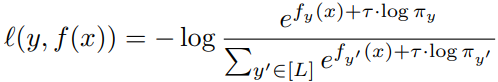

## The implementation of new method with Pytorch-Lightning is extremely straightforward:

In [ ]:
# Since the majority of the training code will be the same as PlainResNet_PL
# So we will directly inherit the PlainResNet_PL to only focus on the changes.
class LogitAdjustment_PL(PlainResNet_PL):

    """
    Logit Adjustment training function.
    """

    name = 'LogitAdjustment_PL'

    def __init__(self, conf, categories, class_counts, **kwargs):
        super(LogitAdjustment_PL, self).__init__(conf=conf, categories=categories, class_counts=class_counts)
        # In the initialization, we need to initialize the logit adjustments based on class frequencies.
        label_freq_norm = np.array(list(self.class_counts.values())) / np.sum(list(self.class_counts.values()))
        self.adjustments = torch.from_numpy(np.log(label_freq_norm ** 1 + 1e-12))

    def training_step(self, batch, batch_idx):
       data, label_ids = batch[0], batch[1]

       # forward
       logits = self.net(data)

       # Here, logit adjustments actually happens
       # The precalculated adjustments are added to the logits
       logits = logits + self.adjustments.cuda()

       # calculate loss
       loss = self.criterion(logits, label_ids)

       # In addition to cross entropy loss, the original LA code also has this regularization term
       # There is too much discussion about this in the paper but adding this won't hurt
       loss_r = 0
       for parameter in self.net.parameters():
           loss_r += torch.sum(parameter ** 2)

       # Final loss is the original loss + this regularizatin term
       loss = loss + 0.0005 * loss_r

       self.log('train_loss', loss)

       return loss

In [ ]:
# Once the training code are built, we need logger, callbacks, and trainer again.
logger = CSVLogger(
    save_dir='/content/CCAI_CameraTrap/log',
    prefix='CCAI',
    name='LogitAdjustment_PL',
    version='0.0'
)

checkpoint_callback = ModelCheckpoint(
    monitor='valid_mac_acc', mode='max', dirpath='/content/CCAI_CameraTrap/weights/', save_top_k=1,
    filename='LogitAdjustment_PL', verbose=True
)

trainer_la = pl.Trainer(
    max_epochs=conf.num_epochs,
    check_val_every_n_epoch=1,
    log_every_n_steps = conf.log_interval,
    accelerator='gpu',
    devices=[0],
    logger=logger,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    profiler=None
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
learner_la = LogitAdjustment_PL(conf, dset_tr.categories, dset_tr.class_counts())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
trainer_la.fit(learner_la, train_dataloaders=loader_tr, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory /content/CCAI_CameraTrap/log/LogitAdjustment_PL/0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/CCAI_CameraTrap/weights exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this wil

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 49: 'valid_mac_acc' reached 50.85308 (best 50.85308), saving model to '/content/CCAI_CameraTrap/weights/LogitAdjustment_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 67.65
             ostrich (1  , tr 102) Acc: 88.24
            steenbok (2  , tr  92) Acc: 26.67
   jackalblackbacked (3  , tr  51) Acc: 78.12
                kudu (4  , tr   9) Acc: 44.44
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 98: 'valid_mac_acc' was not in top 1




         gemsbokoryx (0  , tr 1299) Acc: 73.53
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 46.67
   jackalblackbacked (3  , tr  51) Acc: 37.50
                kudu (4  , tr   9) Acc: 55.56
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 147: 'valid_mac_acc' reached 54.14896 (best 54.14896), saving model to '/content/CCAI_CameraTrap/weights/LogitAdjustment_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 79.41
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 80.00
   jackalblackbacked (3  , tr  51) Acc: 18.75
                kudu (4  , tr   9) Acc: 55.56
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 196: 'valid_mac_acc' reached 63.41912 (best 63.41912), saving model to '/content/CCAI_CameraTrap/weights/LogitAdjustment_PL-v1.ckpt' as top 1




         gemsbokoryx (0  , tr 1299) Acc: 70.59
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 50.00
   jackalblackbacked (3  , tr  51) Acc: 68.75
                kudu (4  , tr   9) Acc: 100.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 245: 'valid_mac_acc' was not in top 1




         gemsbokoryx (0  , tr 1299) Acc: 73.53
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 56.67
   jackalblackbacked (3  , tr  51) Acc: 31.25
                kudu (4  , tr   9) Acc: 100.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 294: 'valid_mac_acc' was not in top 1




         gemsbokoryx (0  , tr 1299) Acc: 64.71
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 56.67
   jackalblackbacked (3  , tr  51) Acc: 56.25
                kudu (4  , tr   9) Acc: 100.00
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 343: 'valid_mac_acc' was not in top 1




         gemsbokoryx (0  , tr 1299) Acc: 82.35
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 66.67
   jackalblackbacked (3  , tr  51) Acc: 40.62
                kudu (4  , tr   9) Acc: 88.89
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 392: 'valid_mac_acc' was not in top 1




         gemsbokoryx (0  , tr 1299) Acc: 88.24
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 66.67
   jackalblackbacked (3  , tr  51) Acc: 56.25
                kudu (4  , tr   9) Acc: 66.67
       hartebeestred (5  , tr   4) Acc: 0.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 441: 'valid_mac_acc' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()




         gemsbokoryx (0  , tr 1299) Acc: 82.35
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 70.00
   jackalblackbacked (3  , tr  51) Acc: 21.88
                kudu (4  , tr   9) Acc: 77.78
       hartebeestred (5  , tr   4) Acc: 0.00


In [ ]:
trainer_la.test(learner_la, dataloaders=loader_val, ckpt_path='/content/CCAI_CameraTrap/weights/LogitAdjustment_PL.ckpt')


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/CCAI_CameraTrap/weights/LogitAdjustment_PL.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/CCAI_CameraTrap/weights/LogitAdjustment_PL.ckpt
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]



         gemsbokoryx (0  , tr 1299) Acc: 88.24
             ostrich (1  , tr 102) Acc: 91.18
            steenbok (2  , tr  92) Acc: 46.67
   jackalblackbacked (3  , tr  51) Acc: 65.62
                kudu (4  , tr   9) Acc: 66.67
       hartebeestred (5  , tr   4) Acc: 11.11
Evaluation output saved to LogitAdjustment_PL_eval.npz.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       valid_mac_acc       │     61.5802001953125      │
│       valid_mic_acc       │     69.59459686279297     │
└───────────────────────────┴───────────────────────────┘

[{'valid_mac_acc': 61.5802001953125, 'valid_mic_acc': 69.59459686279297}]

# Failure cases
- Starting from this section, we are going to do some post training analyses. First is failure cases.
- Failure cases can have many different reasons. So we will print out some random images here and try to find to possible reasons for the failures.
- However, if the samples are of Kudus or Hartebeests, the two rare classes in this dataset, then the cause of the failure is very likely because of the lack of training data.

In [ ]:
eval_outputs = np.load('/content/PlainResNet_PL_eval.npz')
total_preds = eval_outputs['preds']
total_labels = eval_outputs['labels']
total_file_ids = eval_outputs['file_ids']

In [ ]:
fail_file_ids = total_file_ids[total_preds != total_labels]
fail_preds = total_preds[total_preds != total_labels]
fail_labels = total_labels[total_preds != total_labels]

category_dict = {int(i['id']): i['category'] for i in ann['categories']}

This is a gemsbokoryx image predicted as jackalblackbacked
/content/CCAI_CameraTrap/CCAI_Kgalagadi/data/KGA_S1_A05_R1_IMAG0199.JPG


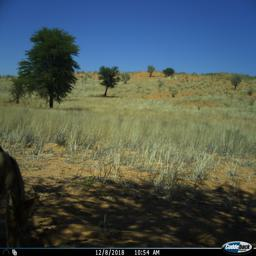

In [ ]:
i = np.random.randint(1, len(fail_file_ids))

# for i in np.arange(1, len(fail_file_ids)):
print('This is a {} image predicted as {}'.format(category_dict[fail_preds[i]],
                                                  category_dict[fail_labels[i]]))
print(fail_file_ids[i])
Image.open(fail_file_ids[i])

## Next,
- The above results are still not good, because for the limited time and resources, the dataset in this tutorial and training epochs are too small.
- In real world, when we have bigger datasets and more computational resources and time, we can have more reasonable calibarated results.
- However, applications don't stop here. We will want to use the calibrated results to trust some of the model predictions. And for the untrustworthy predictions, we will want human validations.
- For example, in our previous [paper](https://www.nature.com/articles/s42256-021-00393-0), we managed to trust 70% predictions on newly collected data from Africa and preserve ~90% accuracy on the confidence predictions. In other words, we can save 70% human annotation effort with a 10% error rate.
- With more robust confidence calibration methods and confidence thresholding, we can tune down the acceptable error rate and still have a good proportion of saved human effort.
- The goal is always providing some automated trustworthy predictions to actually save human effort.